# 1 Design a trading strategy

a. Choose a tradeable instrument to express your view:
A tradeable instrument I choose is the Foreign Exchange: GBPUSD 30 minute data (Jan 2014 - Dec 2018).

b. Choose explanatory variables (feature): 
1. Relative Strength Index RSI: a popular momentum oscillator
2. Stochastic Oscillator SO: another popular momentum oscillator
3. William %R: a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels
4. Moving Average Convergence Divergence
5. Price Rate of Change
6. On Balance Volume

c. Define strategy parameters:
1. Calibration period: monthly. Becuase foreign exchange rate is easily affected by the political events happening around the world.
2. Rebalancing frequency: Buy Impulse Signal is when the 30 step ahead prediction changes from -1 to +1 and Sell Impulse Signal is when 30 step ahead price prediction changes from +1 to -1.

d. Data/Feature engineering:
1. Target(Output) is the label that we want to predict. We calculate six targets to know the market direction, 1 step ahead, 3 step ahead, 5 step ahead, 10 step ahead and 14 step ahead and 30 step ahead. It equals to +1 if the FX GBPUSD rate increases otherwise -1.
2. We can use the TA-LIB python library which has all the six features predefined as functions. 

e. Choose a model:
1. Random Forest: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 
2. A random forest classifier aimed at determining whether a currency pair will be higher or lower after some given amount of days.
3. Parameters: (1) n_estimators: The number of trees in the forest. (2) criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. (3) max_depth: The maximum depth of the tree. (4) min_samples_split: The minimum number of samples required to split an internal node. etc.

f. Describe how you will calibrate/tune/learn the parameters, including the data time frame:
1. Cross validation: In 5-Fold CV, we further split our training set into 5 number of subsets, called folds. We then iteratively fit the model 5 times, each time training the data on 4 of the folds and evaluating on the Kth fold (called the validation data).
2. Criterion: choose Gini impurity.
3. n_estimators: choose as high value as our processor can handle because this makes our predictions stronger and more stable.

g. Describe how you will test the results, including the data time frame. Include specific metrics:
1. From the statistical perspective, using cross validation and training the model 5 times, we calculate the accuracy_score of random forest model everytime using: 
    sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None). 
2. From the practical perspective, we use our model to trade in real historical market competing with the market average to check whether our model outperforms market average.

# 2 Shrink the covariance matrix

a. Understanding of the shrunk-covariance methodology: 
    (1) The shrunk-covariance methodolgy tends to pull the most extreme coefficients towards more central values in order to reduce estimation error systematically.
    (2) The shrinkage target of Ledoit and Wolf is to minimize the Mean Squred Error bewteen the estimated and the real covariance matrix while OAS yields a smaller MSE than Ledoit and Wolf.

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import random
import sklearn.covariance
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch

X = np.random.normal(size=(1000, 20))
# Don't use: starX = X
starX = X.copy()
starX[:,-1] = starX[:,0] + 0.0001*np.random.normal(size=(1000))
starX[:,-2] = starX[:,0] + 0.0001*np.random.normal(size=(1000))

In [2]:
cov_X = np.cov(X.transpose())
cov_starX = np.cov(starX.transpose())

In [3]:
def conNumOfLw(cov_mat):
    lwCov, _ = sklearn.covariance.ledoit_wolf(cov_mat)
    lwConNum = np.linalg.cond(lwCov)
    return lwConNum

def conNumOfOAS(cov_mat):
    oasCov, _ = sklearn.covariance.oas(cov_mat)
    oasConNum = np.linalg.cond(oasCov)
    return oasConNum

print('OAS of X:', conNumOfOAS(X), 'Ledoit&Wolf of X:', conNumOfLw(X))
print('OAS of X*:', conNumOfOAS(starX), 'Ledoit&Wolf of X*:', conNumOfLw(starX))

OAS of X: 1.01765115252 Ledoit&Wolf of X: 1.02206271058
OAS of X*: 48.492414994 Ledoit&Wolf of X*: 49.2770137609


e. Difference between the two methods: 
    The condition number of OAS method is smaller than that of Ledoit and Wolf's method of X which demonstrates that the OAS method's convergence is better under the assumption that the data are Gaussian. 

# 3 Hierarchical Risk Parity

In [4]:
# a. Calculate Daily Returns
df = pd.read_csv('Data.csv', parse_dates=True, index_col ='Date')
# df_return = np.log(df / df.shift())
df_return = df.pct_change()[1:]
df_return.head()

,AGG,TLT,IEF,LQD,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,EFA,EWJ,EWW,EWY,EZU
Date,,,,,,,,,,,,,,,,,,
2017-09-19,-0.000546,-0.002458,-0.001119,0.000579,0.005144,0.004083,0.007582,0.001003,0.004422,-0.003074,-0.002030,-0.007872,-0.000896,0.004696,0.005792,-0.004650,0.003293,0.004875
2017-09-20,-0.000820,0.000715,-0.001960,-0.001240,0.003529,0.006778,0.005941,0.007301,-0.004064,-0.009614,-0.007396,0.000977,0.003362,-0.002191,0.000360,0.003774,-0.005280,-0.004851
2017-09-21,-0.000182,-0.000556,-0.001309,0.000000,-0.002110,0.000299,0.002362,0.002985,-0.005441,-0.009524,-0.000186,-0.005122,-0.001675,-0.002049,-0.003958,-0.002327,-0.000143,0.000696
2017-09-22,0.000729,0.002861,0.001779,0.001324,-0.003524,0.005085,-0.001178,0.002551,0.000513,-0.002959,-0.008198,0.000000,0.001678,0.003080,0.001084,0.004665,-0.005166,0.002088
2017-09-25,0.002369,0.006260,0.002991,0.003720,0.001768,0.014435,-0.001180,0.000000,-0.011791,0.007233,0.009205,-0.002942,-0.002122,-0.005703,0.002165,-0.007144,-0.006491,-0.010880


In [5]:
# b. Calculate covariance matrix
cov_mat = df_return.cov().values   # df.cov() shows row&col names

In [6]:
# c. Calculate condition number
np.linalg.cond(cov_mat)

6084.0113625921376

In [7]:
# d. Use OAS, calculate condition number
OAScov_mat, _ = sklearn.covariance.oas(df_return)
np.linalg.cond(OAScov_mat)

1089.1741249819468

In [8]:
# e. Agglomerative clustering

# compute a correlation matrix of daily returns
corr_mat = df_return.corr().values
# compute a distance matrix
dist = (0.5*(1-corr_mat))**0.5
print(dist.shape)
# cls = linkage(dist, 'single')
cls = linkage(dist, 'complete')
print(cls)

(18, 18)
[[ 13.          17.           0.25294926   2.        ]
 [  1.           2.           0.28627021   2.        ]
 [  8.          12.           0.36669571   2.        ]
 [  0.          19.           0.37191749   3.        ]
 [  4.           7.           0.39707263   2.        ]
 [ 14.          18.           0.502477     3.        ]
 [  6.          22.           0.53789058   3.        ]
 [ 11.          20.           0.54204866   3.        ]
 [ 24.          25.           0.61175894   6.        ]
 [ 16.          23.           0.62432638   4.        ]
 [  5.          26.           0.68857554   7.        ]
 [  3.          21.           0.70997163   4.        ]
 [ 27.          28.           0.72540265  11.        ]
 [  9.          15.           0.86751858   2.        ]
 [ 30.          31.           0.96645772  13.        ]
 [ 10.          29.           1.26213991   5.        ]
 [ 32.          33.           2.21735846  18.        ]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


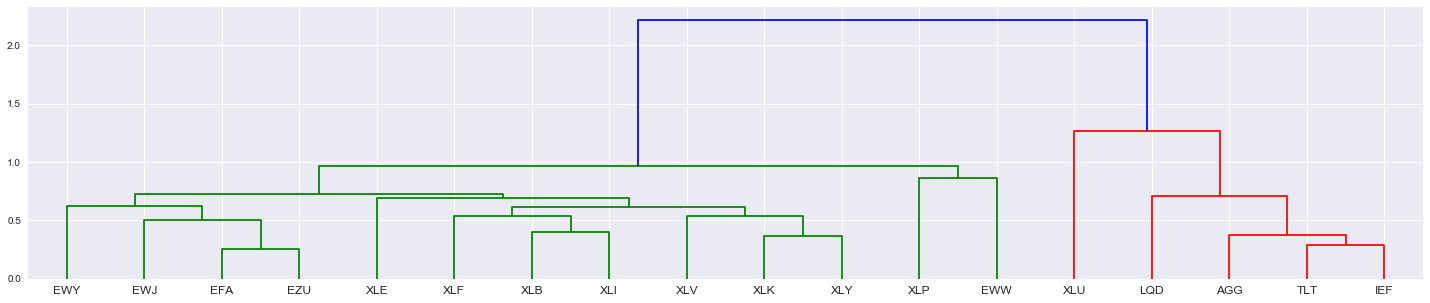

In [9]:
# f. Plot Dendrogram – describe the different clusters

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
fig = plt.figure(figsize=(25, 5))
dn = dendrogram(cls, labels=df_return.columns)
plt.show()

f. describe the different clusters:

In [10]:
# g. Get HRP weights

def getIVP(cov):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [11]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = (0.5*(1-corr_mat))**0.5
    link = linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

w_hrp = getHRP(df_return.cov(), df_return.corr())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


In [12]:
w_hrp

AGG    0.431040
EFA    0.010560
EWJ    0.008848
EWW    0.013448
EWY    0.007237
EZU    0.009033
IEF    0.190538
LQD    0.186131
TLT    0.037026
XLB    0.003220
XLE    0.007967
XLF    0.006228
XLI    0.003272
XLK    0.004477
XLP    0.028969
XLU    0.037127
XLV    0.008508
XLY    0.006370
dtype: float64